# Seasonal and time series analysis

## Initial setup

### Load modules

In [1]:
# modules in this package
import load_and_preprocess as lp
import analysis as at
import bic_and_aic as ba
import plot_tools as pt
import file_io as io
import numpy as np
import xarray as xr
import density
import gmm
# plotting tools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
import cmocean
# os tools
import os.path

# suppress a particular warning
import warnings
warnings.filterwarnings('ignore', 'RuntimeWarning: All-NaN slice encountered')

### Set runtime parameters (file locations, etc.)

In [2]:
# set locations and names
descrip = 'WeddellOnly' # extra description for filename
data_location = '../../so-chic-data/' # input data location
classified_data_location = 'models/profiles_-65to80lon_-85to-30lat_20to1000depth_5K_allDomain_revised.nc'
ploc = 'plots/plots_WeddellClassOnly_top1000m_K04_forPaper/'
#ploc = 'tests/'
dloc = 'models/'

# if plot directory doesn't exist, create it
if not os.path.exists(ploc):
    os.makedirs(ploc)

# save the processed output as a NetCDF file?
saveOutput = False

# number of PCA components (roughly 95%)
n_pca = 6

# make decision about n_components_selected (iterative part of analysis)
n_components_selected = 4

#longitude and latitude range
lon_min = -65
lon_max =  80
lat_min = -80
lat_max = -45
# depth range
zmin = 20.0
zmax = 1000.0
# density range
sig0range = (26.6, 28.0)

# temperature and salinity ranges for plotting
lon_range=(lon_min, lon_max)
lat_range=(lat_min, lat_max)
Trange=(-2.2, 6.0)
Srange=(33.5, 35.0)

# create filename for saving GMM and saving labelled profiles
pca_fname = dloc + 'pca_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_pca)) + descrip
gmm_fname = dloc + 'gmm_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_components_selected)) + 'K_' + descrip
fname = dloc + 'profiles_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_components_selected)) + 'K_' + descrip + '.nc'

# colormap
colormap = plt.get_cmap('Dark2', n_components_selected)
colormap_cividis = plt.get_cmap('cividis', 20)

### Load classified profile data

In [3]:
dfp = xr.open_dataset("weddell_classified_n4.nc")
# select the top pressure level for plotting purposes
df1D = dfp.isel(depth=0)

## Map out individual seasons

Helper function to add season as a coordinate

In [4]:
def add_season_coordinate(dfp):
    
    import xarray as xr
    
    nsize = dfp.profile.size
    month = dfp.month.values
    season = np.zeros((nsize,), dtype='int')
    
    # assign season based on the month (1=DJF, 2=MAM, 3=JJA, 4=SON)
    for i in range(nsize):
        if (month[i]==12 or month[i]==1 or month[i]==2):
            season[i] = 1
        elif (month[i]==3 or month[i]==4 or month[i]==5):
            season[i] = 2
        elif (month[i]==6 or month[i]==7 or month[i]==8):
            season[i] = 3
        elif (month[i]==9 or month[i]==10 or month[i]==11):
            season[i] = 4
        else:
            season[i] = None

    # add season to DataArray
    dseason = xr.DataArray(season, dims=['profile'])
    dfp['season'] = dseason
    dfp = dfp.set_coords({'season'})
    
    return dfp

In [5]:
dfp = add_season_coordinate(dfp)
dfp

<xarray.Dataset>
Dimensions:        (profile: 28397, depth: 21, CLASS: 4, depth_mid: 20)
Coordinates:
  * profile        (profile) int64 13 14 15 16 ... 142282 142301 142320 142330
    lon            (profile) float64 ...
    lat            (profile) float64 ...
  * depth          (depth) float64 20.0 40.0 60.0 80.0 ... 820.0 910.0 1e+03
    time           (profile) datetime64[ns] ...
    year           (profile) int64 ...
    month          (profile) int64 1 1 1 1 1 1 1 1 1 1 ... 8 8 8 9 9 9 9 9 10 10
  * CLASS          (CLASS) int64 0 1 2 3
  * depth_mid      (depth_mid) float64 30.0 50.0 70.0 90.0 ... 775.0 865.0 955.0
    season         (profile) int64 1 1 1 1 1 1 1 1 1 1 1 ... 3 3 3 4 4 4 4 4 4 4
Data variables: (12/22)
    prof_date      (profile) float64 ...
    prof_YYYYMMDD  (profile) float64 ...
    prof_HHMMSS    (profile) float64 ...
    sig0           (profile, depth) float64 ...
    prof_SA        (profile, depth) float64 ...
    prof_CT        (profile, depth) float64 ...
    ...             ...
    Smin_depth     (profile) float64 ...
    Smax           (profile) float64 ...
    Smax_depth     (profile) float64 ...
    sig0min        (profile) float64 ...
    sig0max        (profile) float64 ...
    imetric        (profile) float64 ...

In [36]:
#pt.plot_hist_map(ploc, dfp.where(dfp.season==1, drop=True),
#                 lon_range, lat_range,
#                 n_components_selected,
#                 c_range=[0,4],
#                 vartype='label',
#                 colormap=colormap,
#                 moreText='DJF')

In [37]:
#pt.plot_hist_map(ploc, dfp.where(dfp.season==2, drop=True),
#                 lon_range, lat_range,
#                 n_components_selected,
#                 c_range=[0,4],
#                 vartype='label',
#                 colormap=colormap,
#                 moreText='MAM')

In [34]:
#pt.plot_hist_map(ploc, dfp.where(dfp.season==3, drop=True),
#                 lon_range, lat_range,
#                 n_components_selected,
#                 c_range=[0,4],
#                 colormap=colormap,
#                 moreText='JJA')

In [35]:
#pt.plot_hist_map(ploc, dfp.where(dfp.season==4, drop=True),
#                 lon_range, lat_range,
#                 n_components_selected,
#                 c_range=[0,4],
#                 colormap=colormap,
#                 moreText='SON')

## T-S histograms by season

# DJF

plot_tools.plot_hist_map


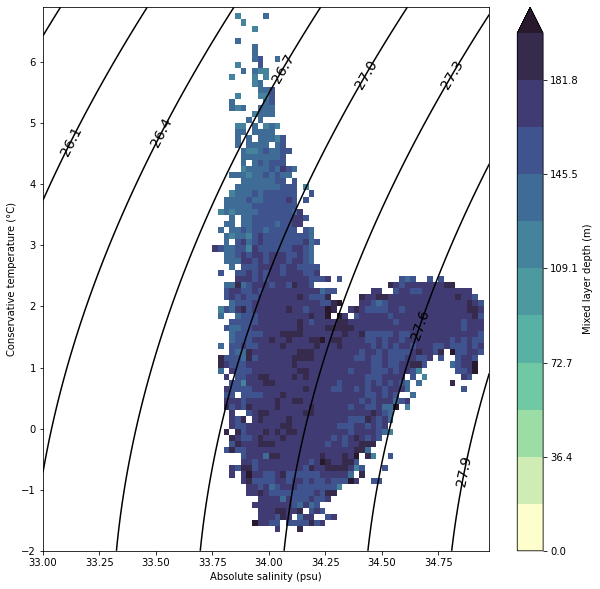

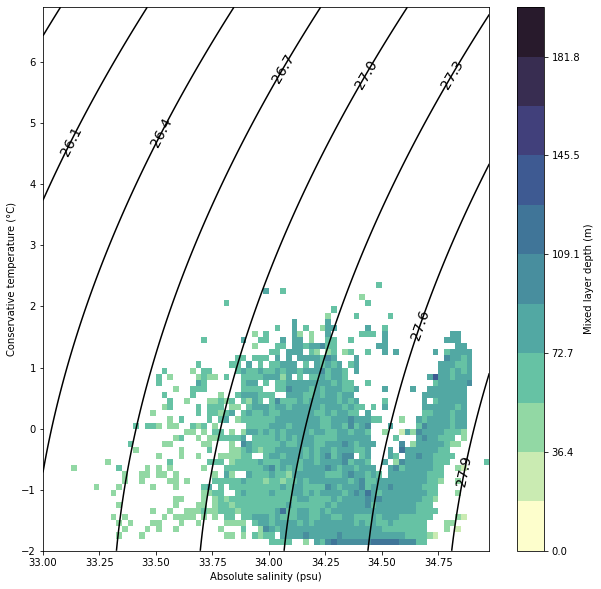

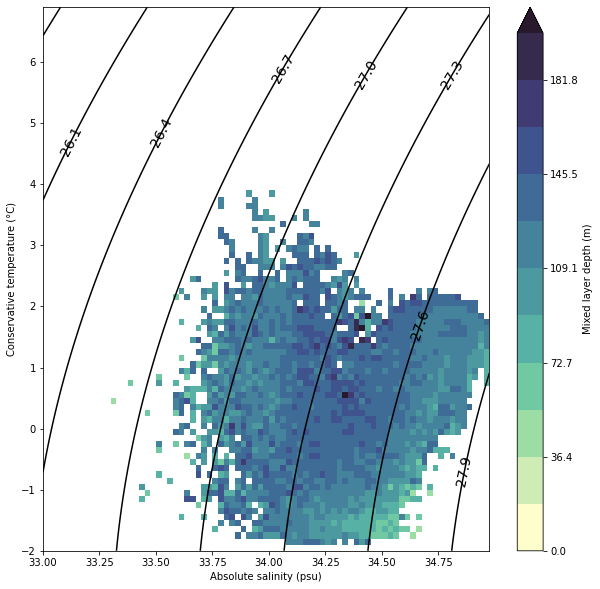

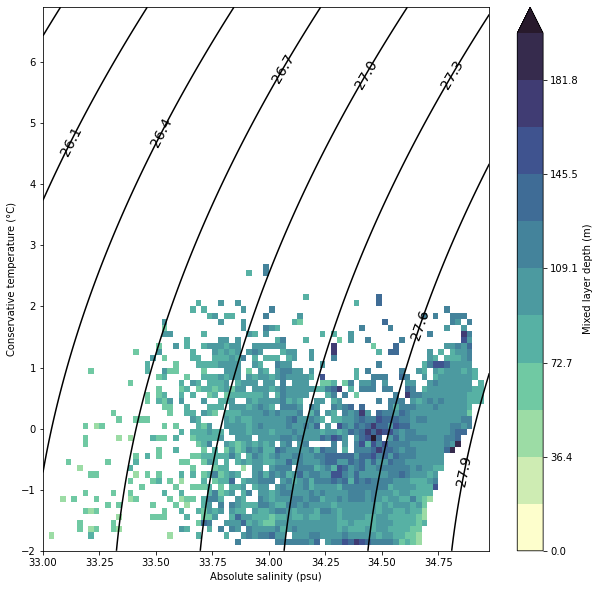

In [29]:
pt.plot_hist_TS(ploc, dfp.where(dfp.season==1, drop=True), n_components_selected,
                sbins = np.arange(33, 35, 0.025), 
                tbins = np.arange(-2, 7, 0.1),
                crange=[0,200],
                vartype='mld',
                colormap=cmocean.cm.deep,
                moreText='DJF')

### T-S MLD MAM

plot_tools.plot_hist_map


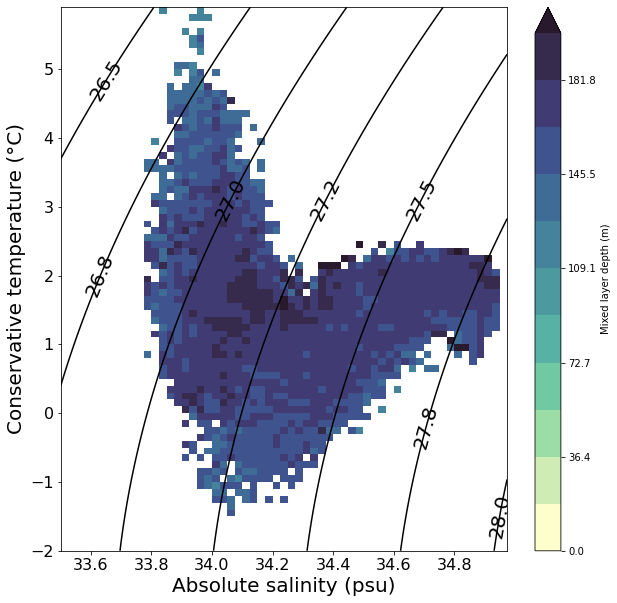

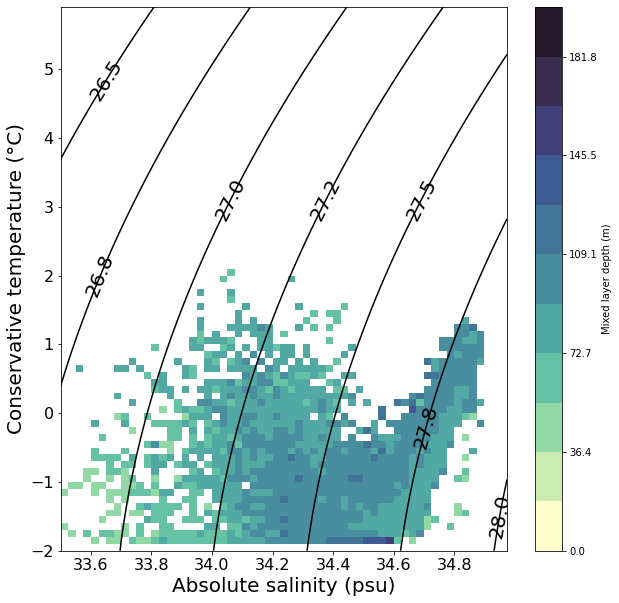

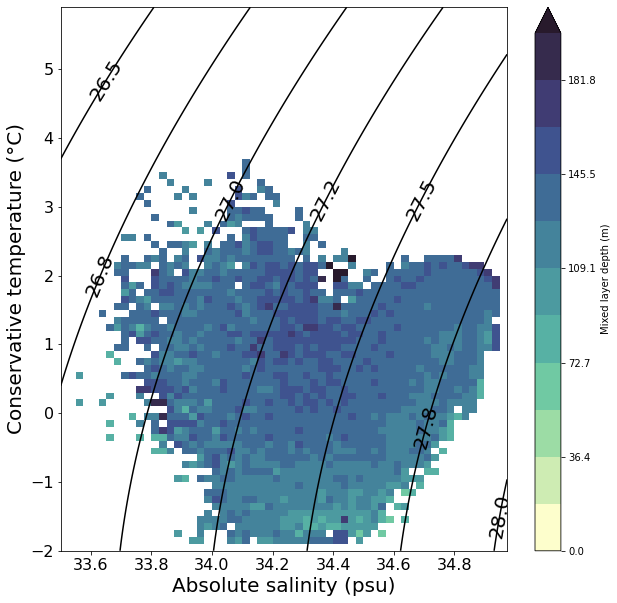

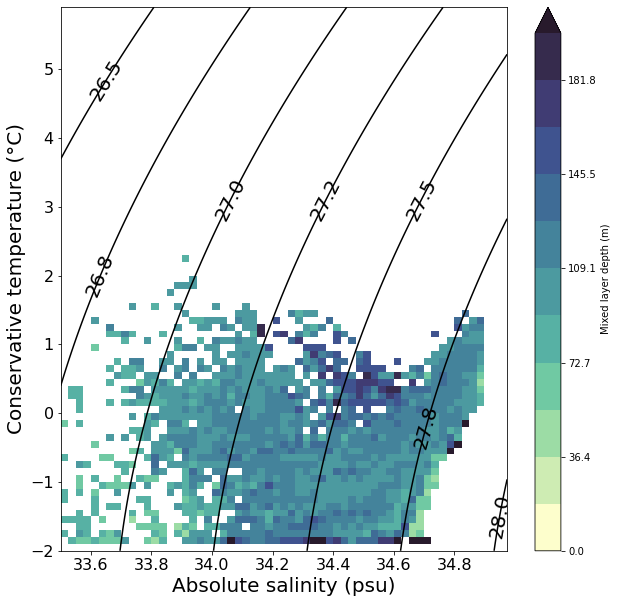

In [61]:
plot_hist_TS(ploc, dfp.where(dfp.season==2, drop=True), n_components_selected,
                sbins = np.arange(33.5, 35, 0.025), 
                tbins = np.arange(-2, 6, 0.1),
                crange=[0,200],
                vartype='mld',
                colormap=cmocean.cm.deep,
                moreText='MAM',
                fs=20)

## T-S MLD JJA

plot_tools.plot_hist_map


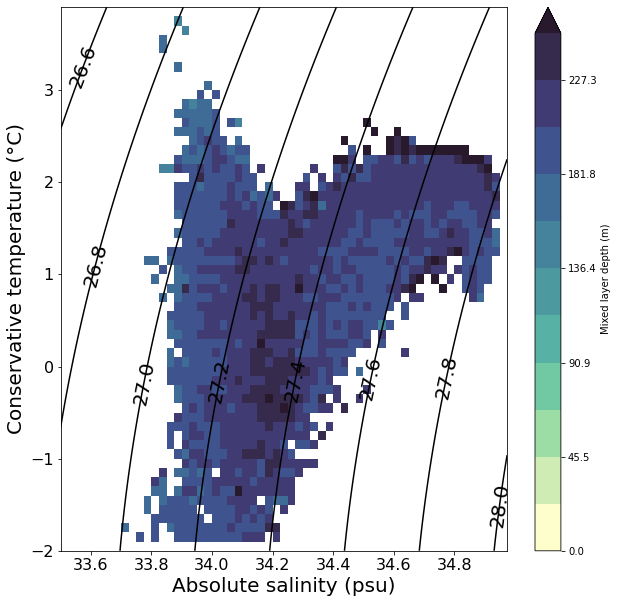

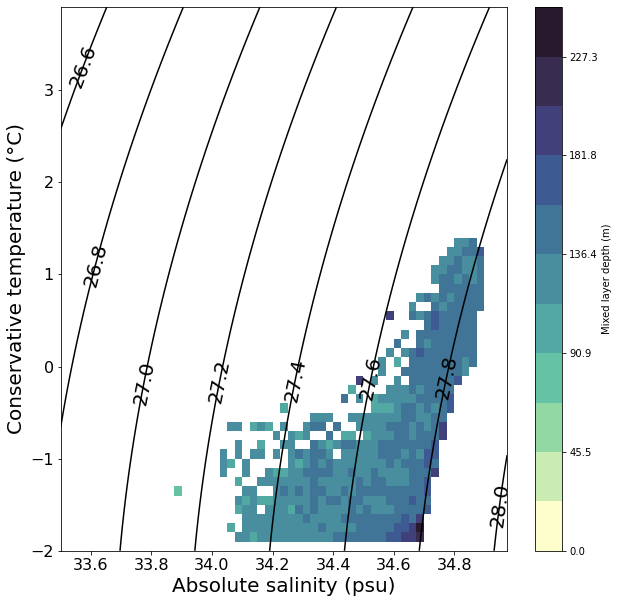

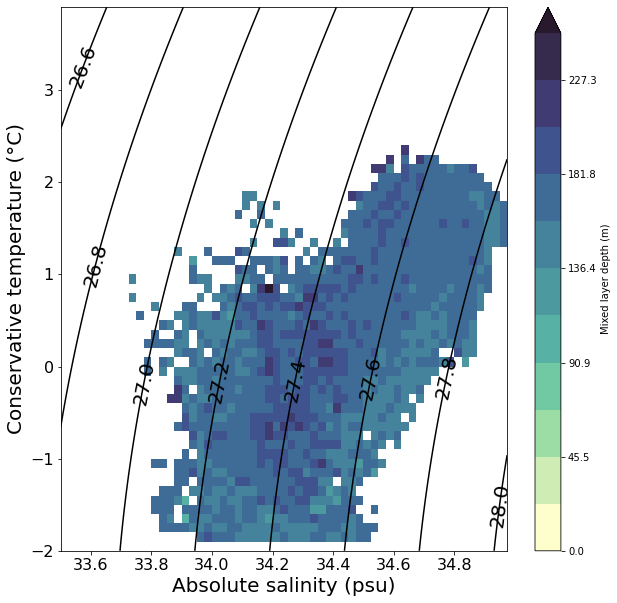

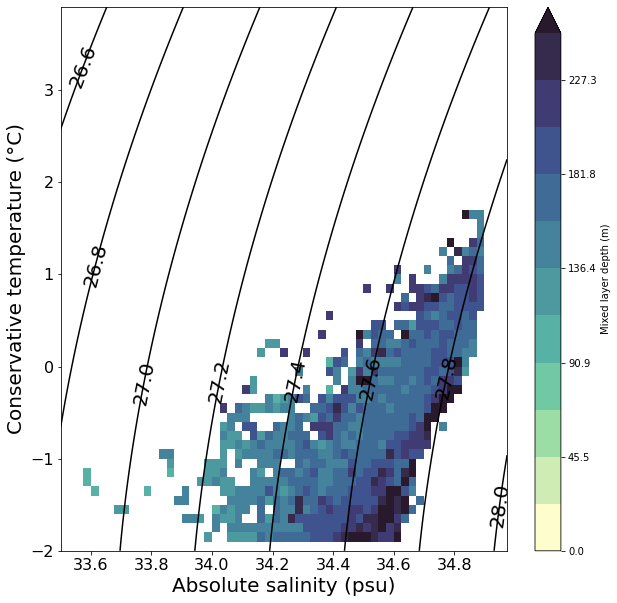

In [63]:
plot_hist_TS(ploc, dfp.where(dfp.season==3, drop=True), n_components_selected,
                sbins = np.arange(33.5, 35, 0.025), 
                tbins = np.arange(-2, 4, 0.1),
                crange=[0,250],
                vartype='mld',
                colormap=cmocean.cm.deep,
                moreText='JJA',
                fs=20)

## T-S MLD SON

plot_tools.plot_hist_map


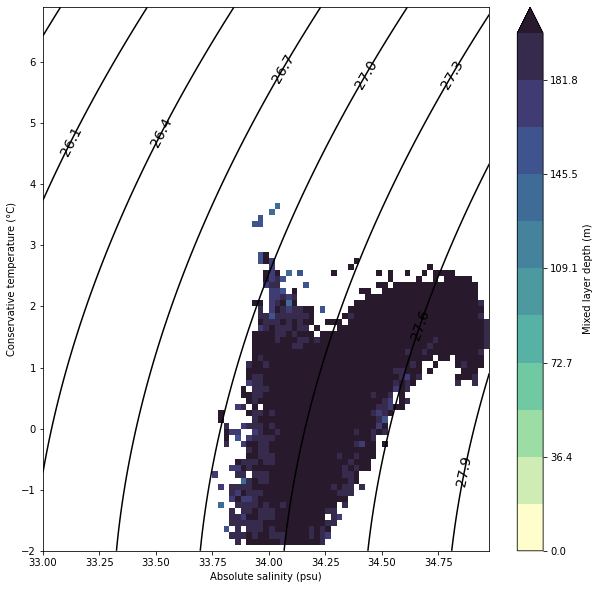

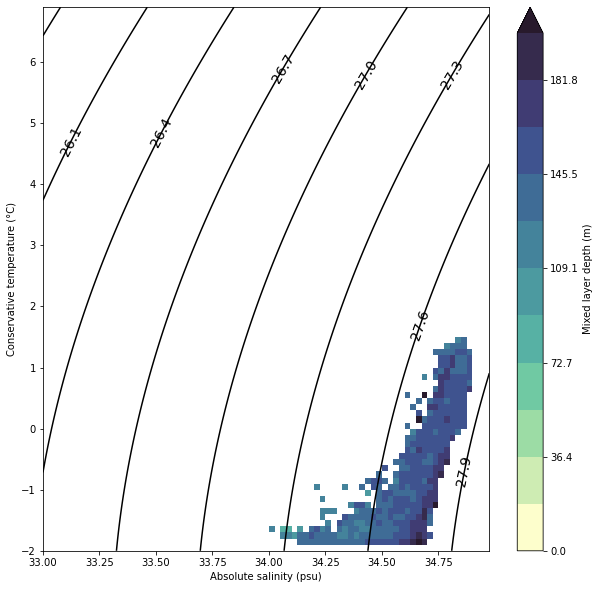

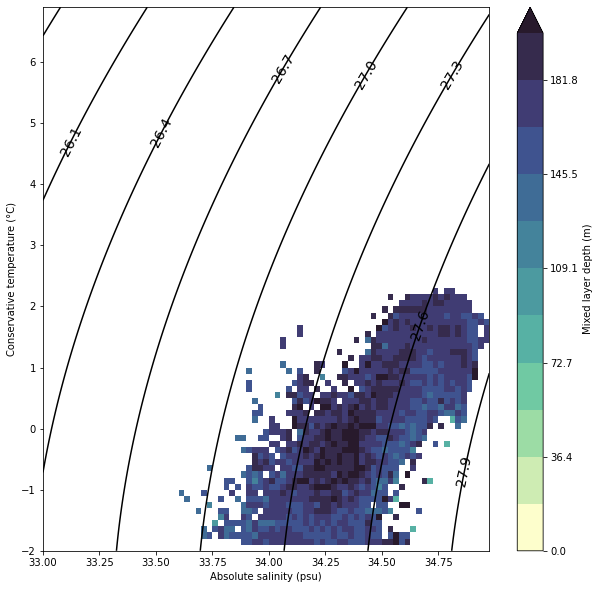

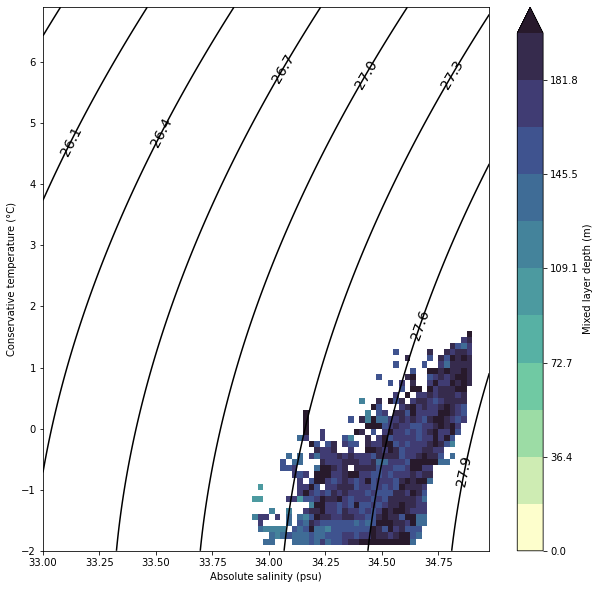

In [32]:
pt.plot_hist_TS(ploc, dfp.where(dfp.season==4, drop=True), n_components_selected,
                sbins = np.arange(33, 35, 0.025), 
                tbins = np.arange(-2, 7, 0.1),
                crange=[0,200],
                vartype='mld',
                colormap=cmocean.cm.deep,
                moreText='SON')

## Profile stats by class and season

### DJF

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


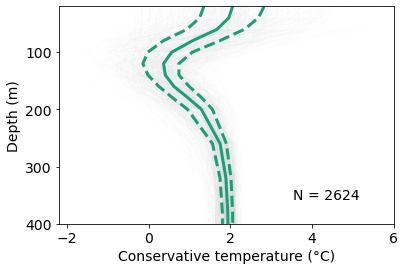

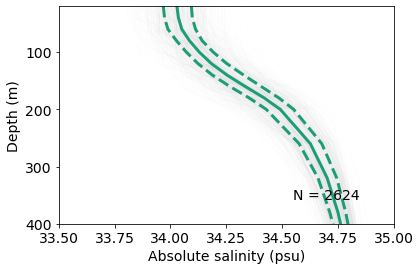

plot_tools.plot_many_profiles


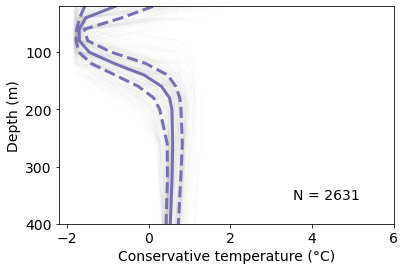

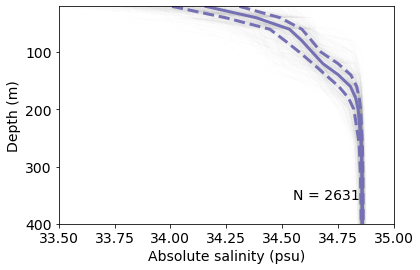

plot_tools.plot_many_profiles


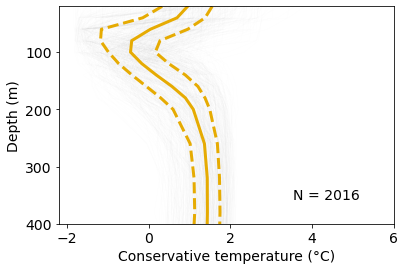

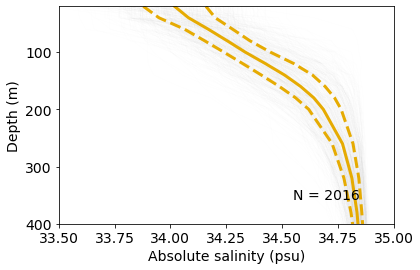

plot_tools.plot_many_profiles


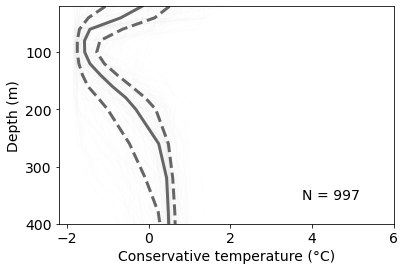

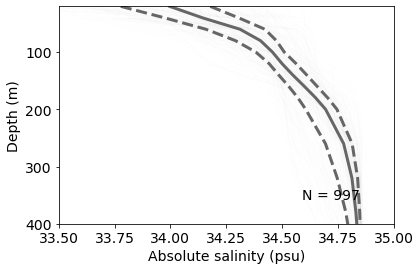

In [14]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp.where(dfp.season==1, drop=True), 
                                  n_components_selected, 
                                  colormap,
                                  zmin=zmin, 
                                  zmax=400,
                                  Tmin=Trange[0], 
                                  Tmax=Trange[1],
                                  Smin=Srange[0], 
                                  Smax=Srange[1],
                                  frac=0.25, 
                                  description='DJF',
                                  withDensity=False)

### MAM

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


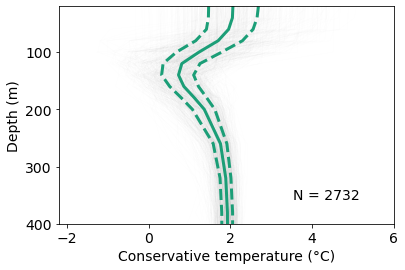

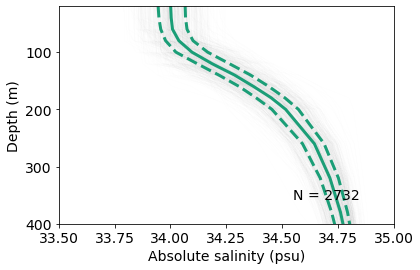

plot_tools.plot_many_profiles


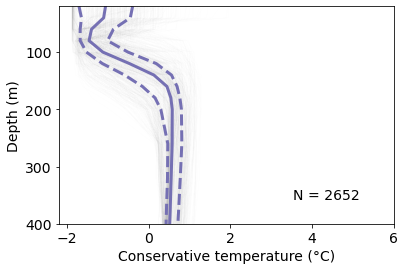

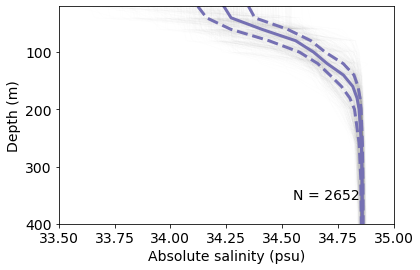

plot_tools.plot_many_profiles


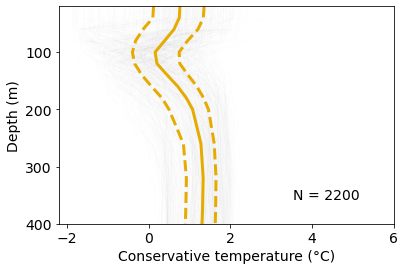

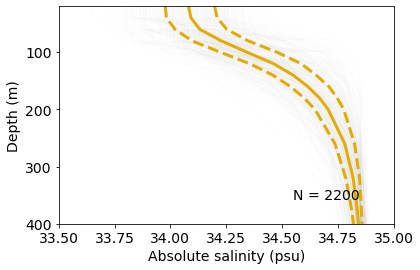

plot_tools.plot_many_profiles


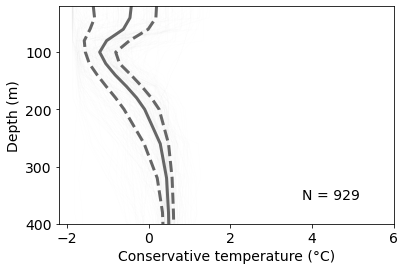

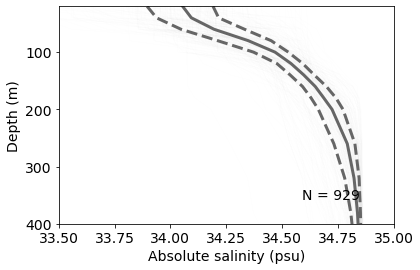

In [15]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp.where(dfp.season==2, drop=True), 
                                  n_components_selected, 
                                  colormap,
                                  zmin=zmin, 
                                  zmax=400,
                                  Tmin=Trange[0], 
                                  Tmax=Trange[1],
                                  Smin=Srange[0], 
                                  Smax=Srange[1],
                                  frac=0.25, 
                                  description='MAM',
                                  withDensity=False)

### JJA

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


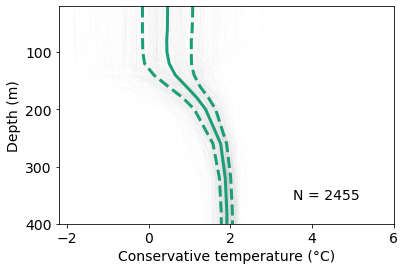

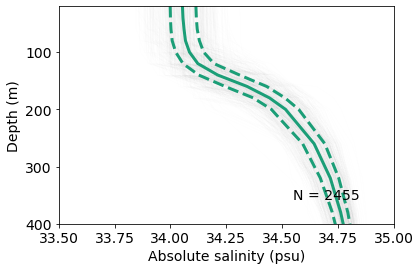

plot_tools.plot_many_profiles


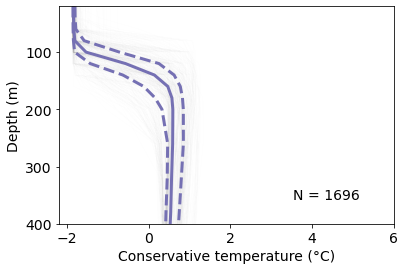

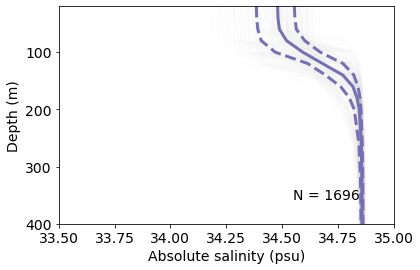

plot_tools.plot_many_profiles


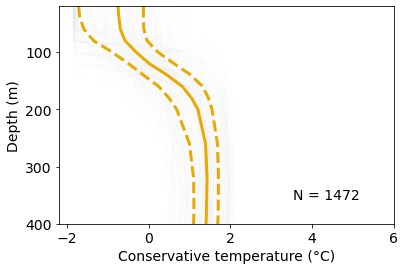

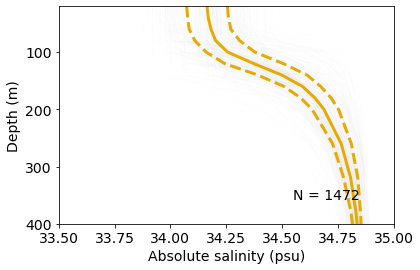

plot_tools.plot_many_profiles


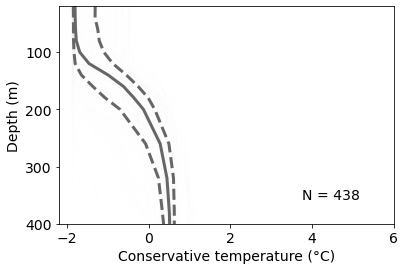

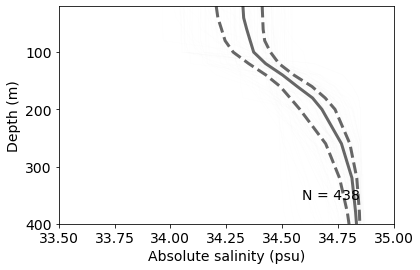

In [16]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp.where(dfp.season==3, drop=True), 
                                  n_components_selected, 
                                  colormap,
                                  zmin=zmin, 
                                  zmax=400,
                                  Tmin=Trange[0], 
                                  Tmax=Trange[1],
                                  Smin=Srange[0], 
                                  Smax=Srange[1],
                                  frac=0.25, 
                                  description='JJA',
                                  withDensity=False)

### SON

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


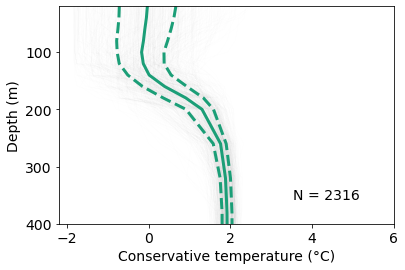

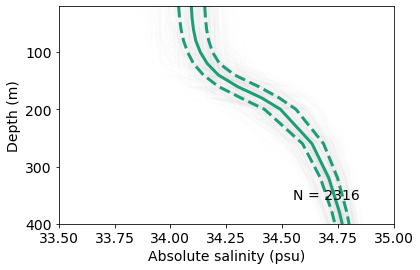

plot_tools.plot_many_profiles


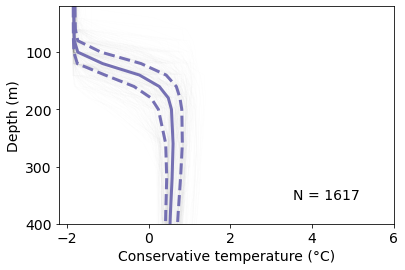

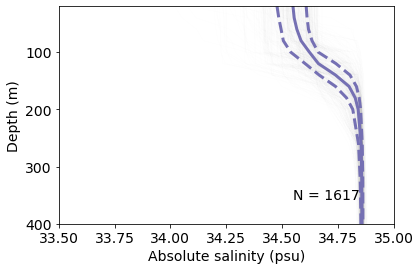

plot_tools.plot_many_profiles


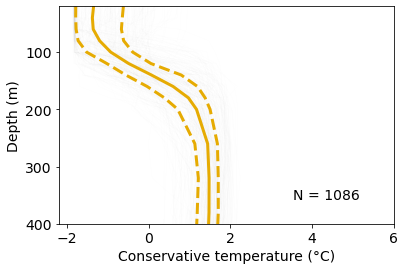

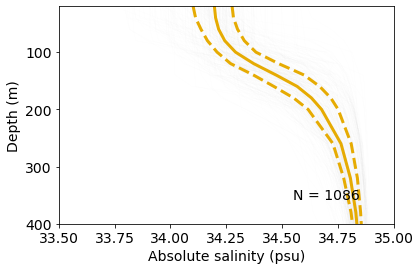

plot_tools.plot_many_profiles


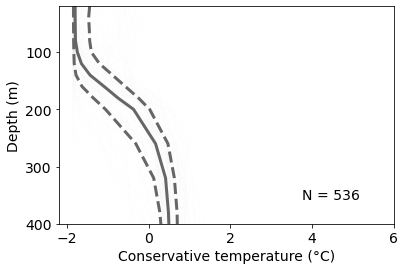

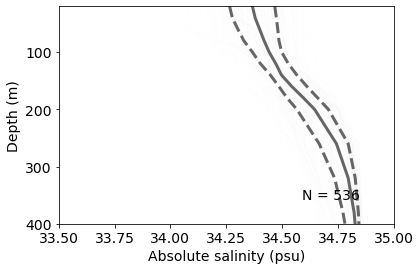

In [17]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp.where(dfp.season==4, drop=True), 
                                  n_components_selected, 
                                  colormap,
                                  zmin=zmin, 
                                  zmax=400,
                                  Tmin=Trange[0], 
                                  Tmax=Trange[1],
                                  Smin=Srange[0], 
                                  Smax=Srange[1],
                                  frac=0.25, 
                                  description='SON',
                                  withDensity=False)

## Calculate statistics over time 

### Tmax

analysis.calculate_stats_over_time


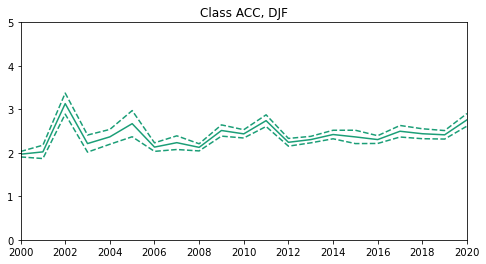

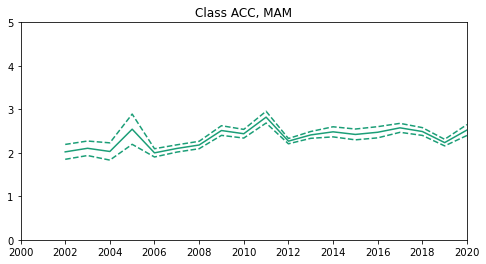

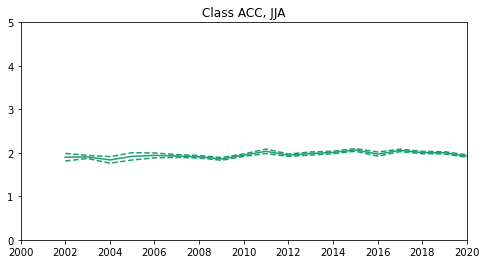

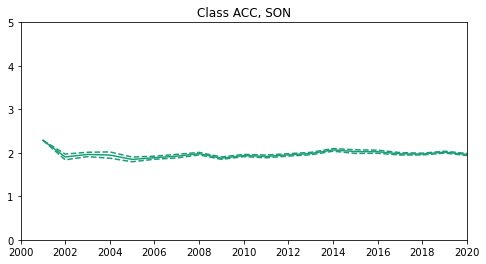

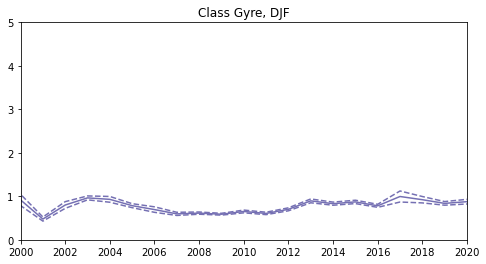

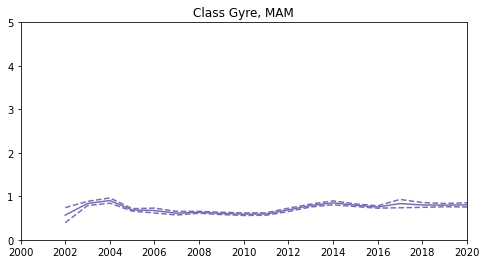

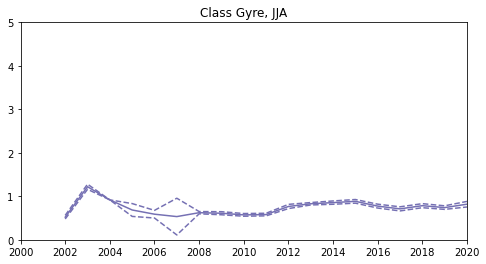

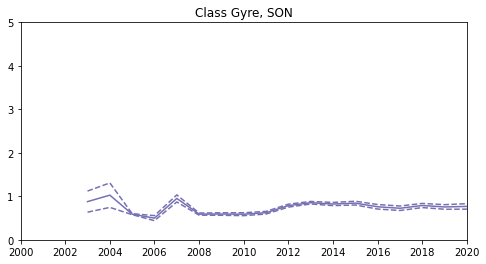

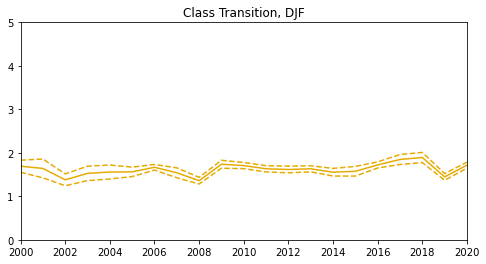

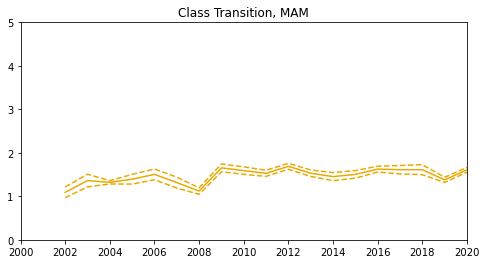

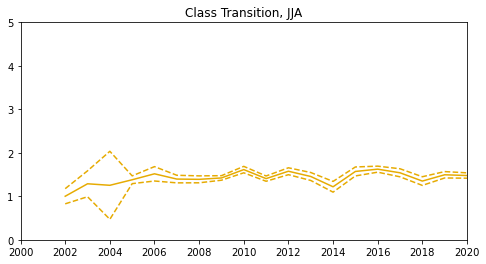

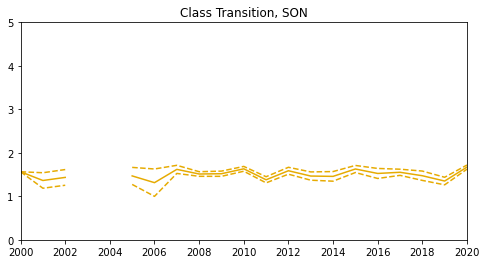

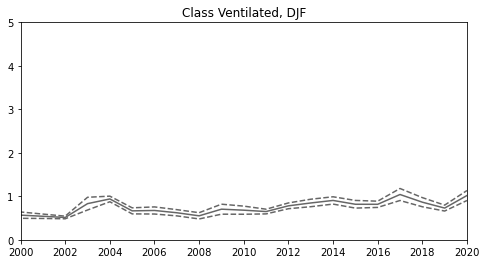

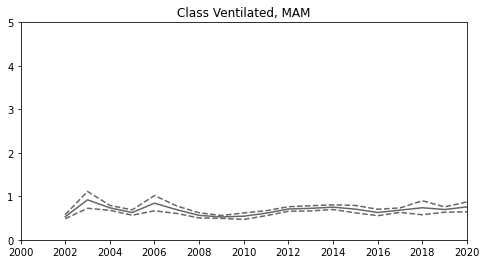

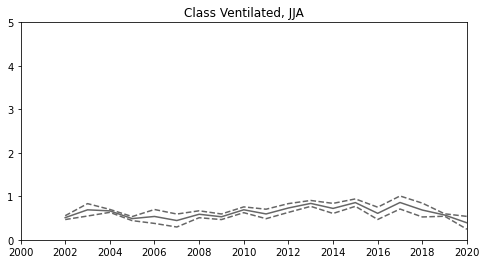

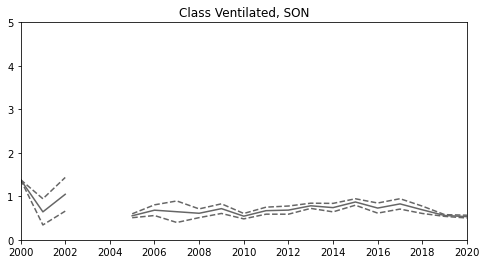

In [84]:
Tmax_mean, Tmax_std, Tmax_N = at.calculate_stats_over_time(dfp, varName='Tmax')
plot_stats_from_analysis(ploc, dfp, Tmax_mean, Tmax_std, Tmax_N, colormap, n_components_selected, varName='Tmax', xlim=[2000, 2020], ylim=[0.0, 5.0])

### Tmin

analysis.calculate_stats_over_time


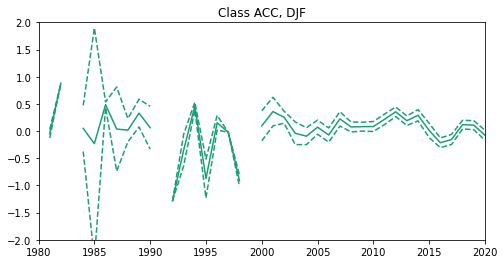

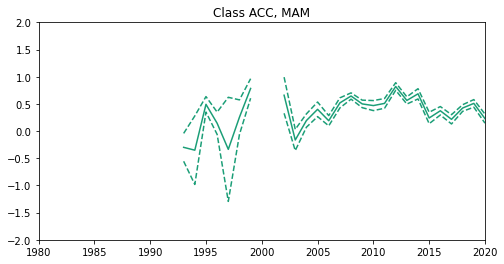

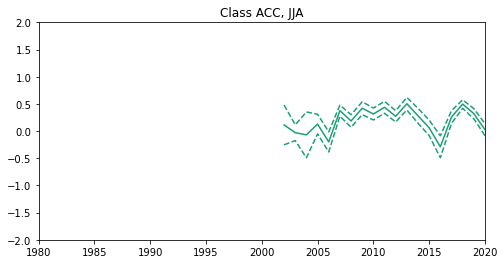

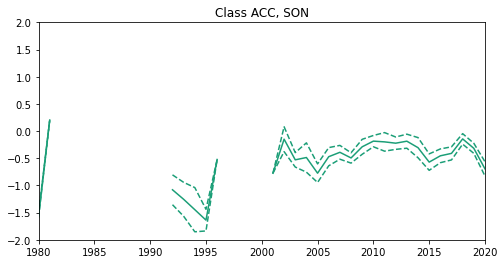

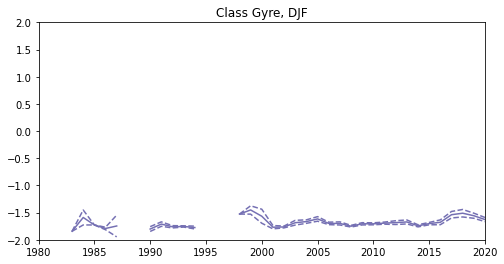

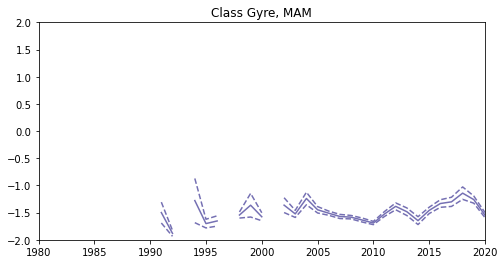

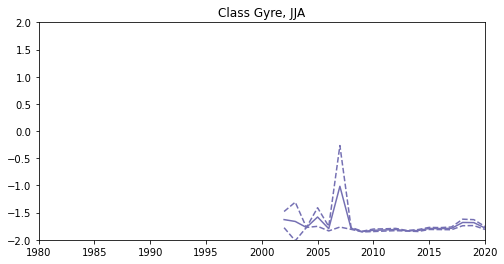

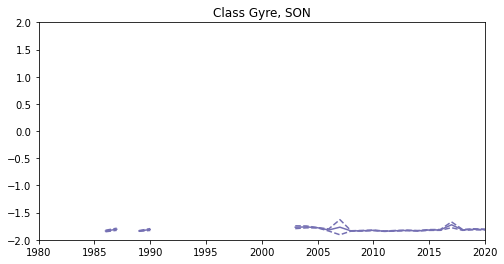

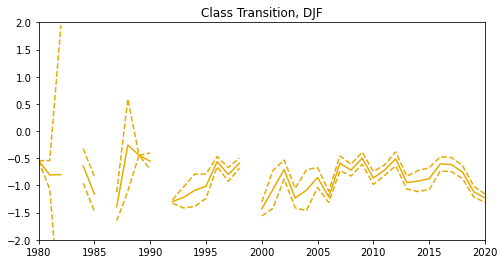

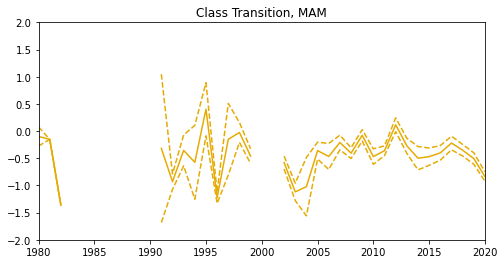

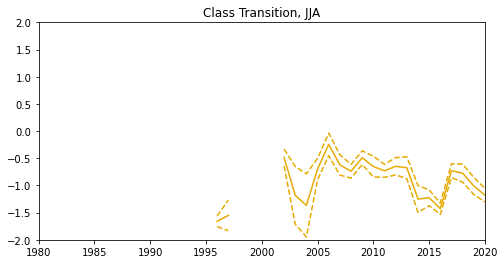

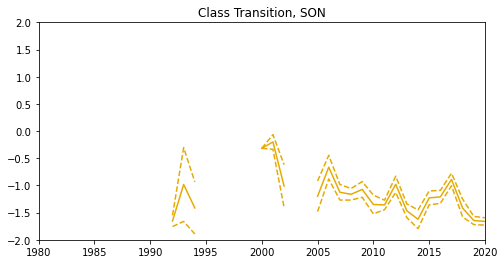

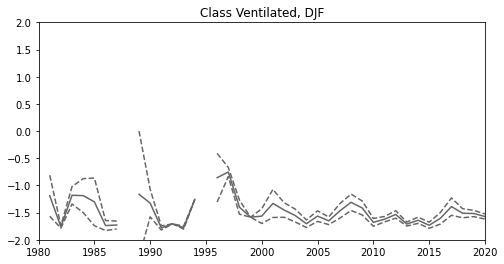

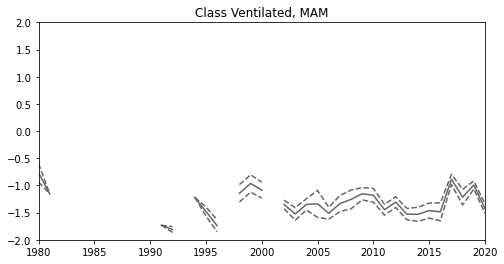

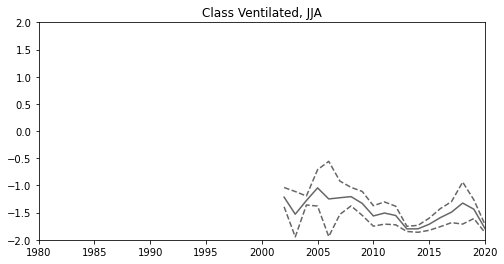

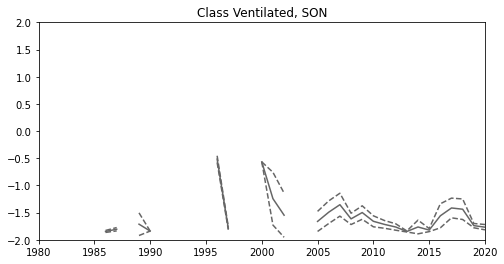

In [19]:
Tmin_mean, Tmin_std, Tmin_N = at.calculate_stats_over_time(dfp, varName='Tmin')
pt.plot_stats_from_analysis(ploc, dfp, Tmin_mean, Tmin_std, Tmin_N, colormap, n_components_selected, varName='Tmin', xlim=[1980, 2020], ylim=[-2.0, 2.0])

### Smax

analysis.calculate_stats_over_time


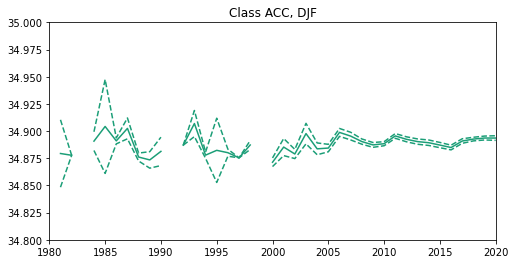

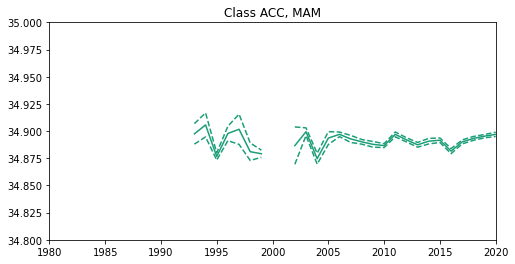

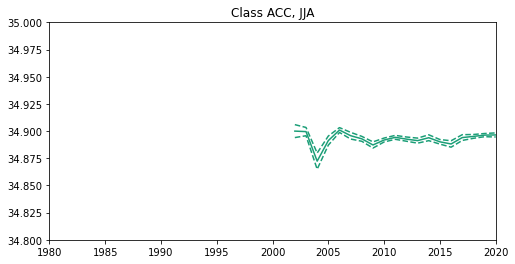

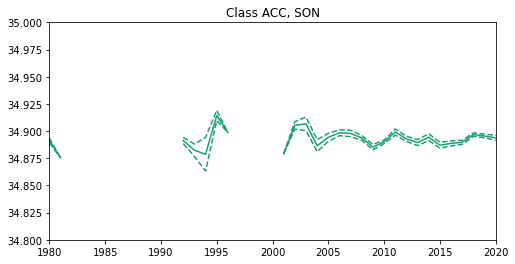

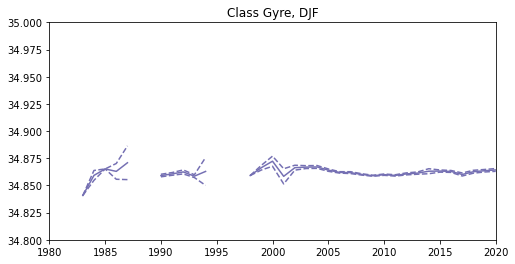

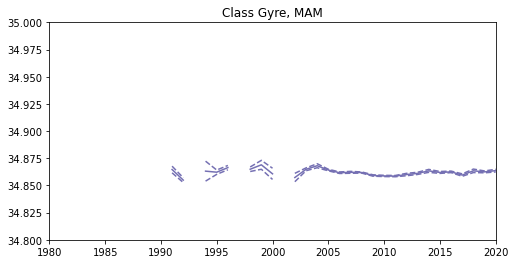

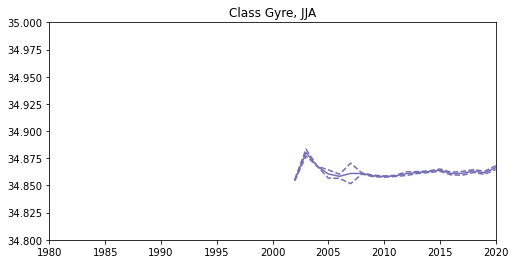

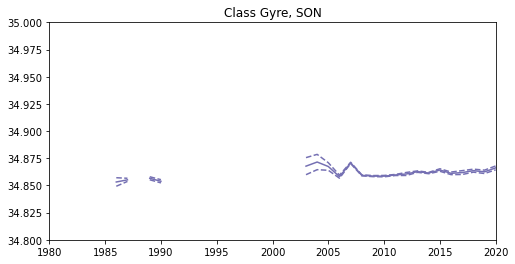

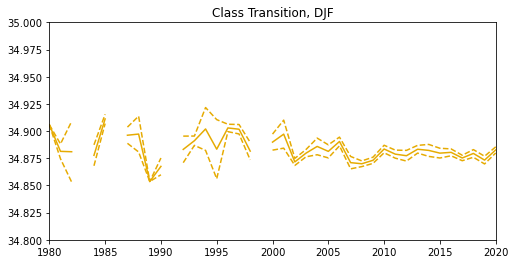

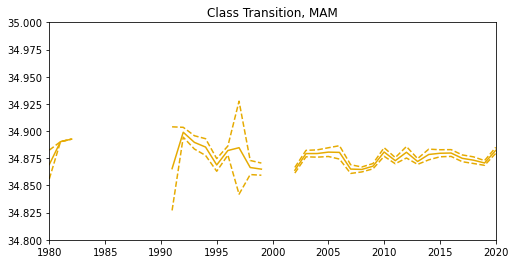

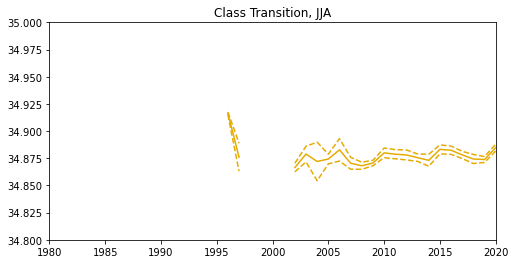

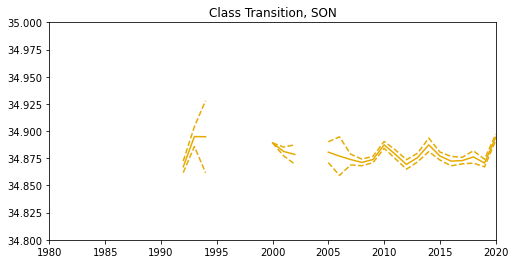

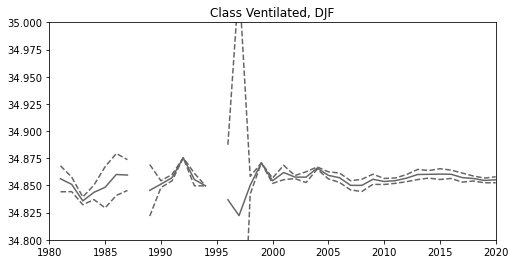

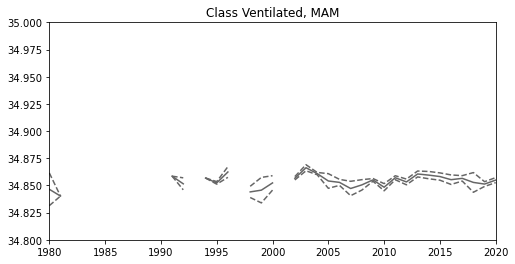

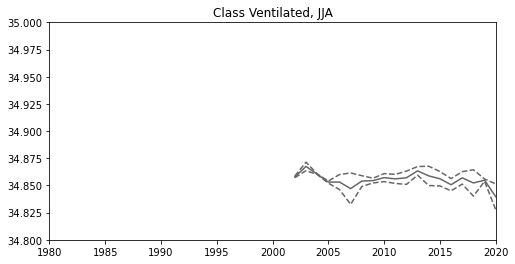

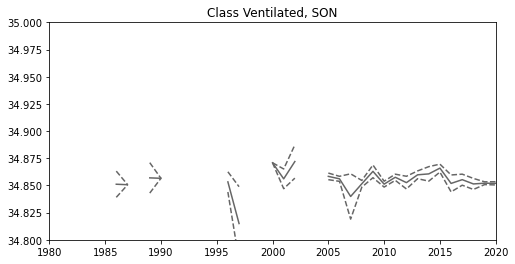

In [20]:
Smax_mean, Smax_std, Smax_N = at.calculate_stats_over_time(dfp, varName='Smax')
pt.plot_stats_from_analysis(ploc, dfp, Smax_mean, Smax_std, Smax_N, colormap, n_components_selected, varName='Smax', xlim=[1980, 2020], ylim=[34.8, 35.0])

### Smin

analysis.calculate_stats_over_time


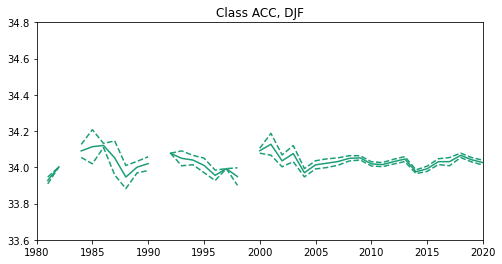

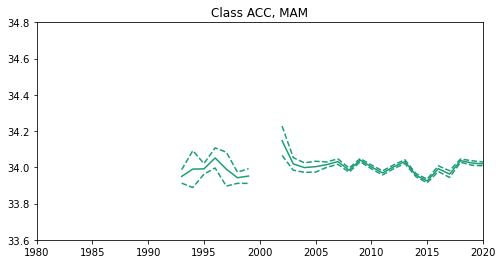

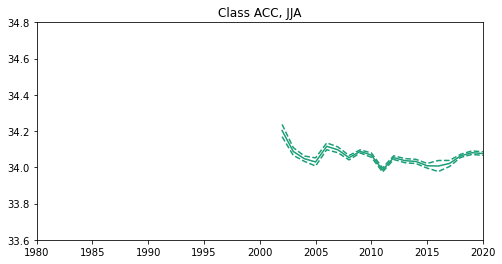

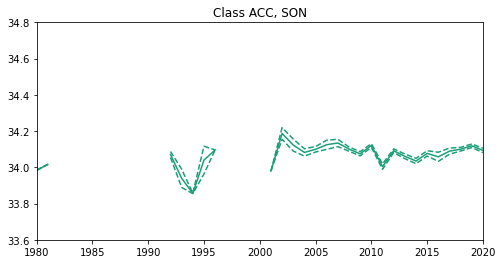

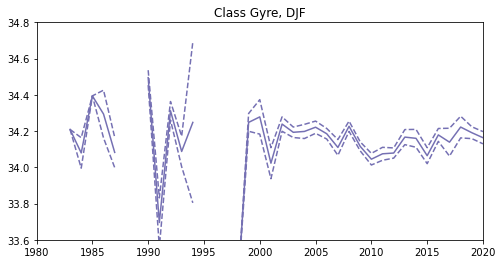

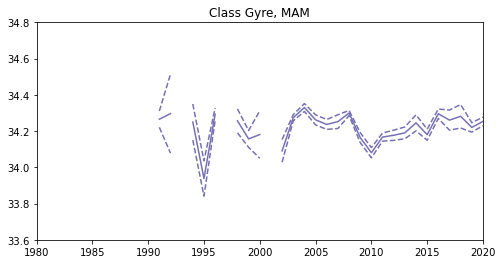

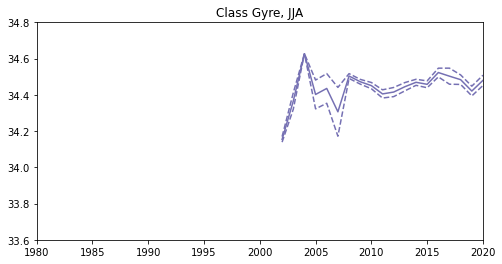

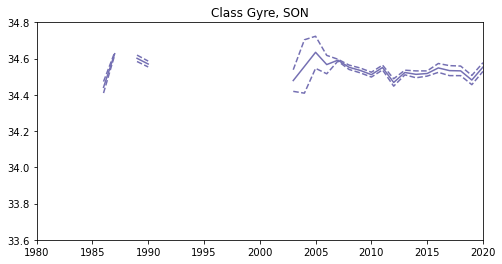

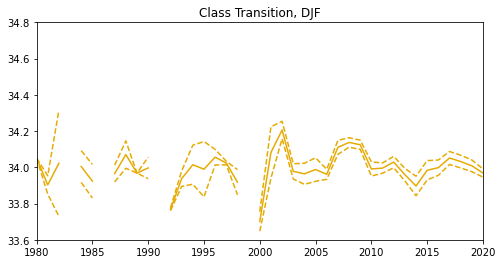

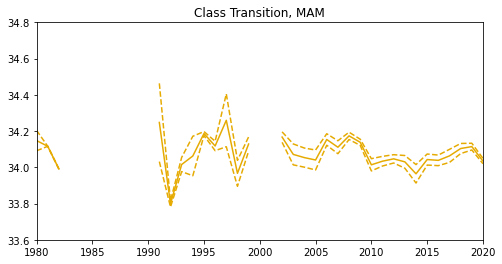

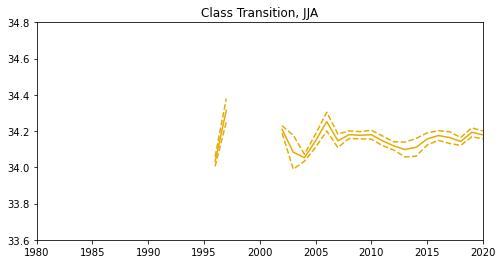

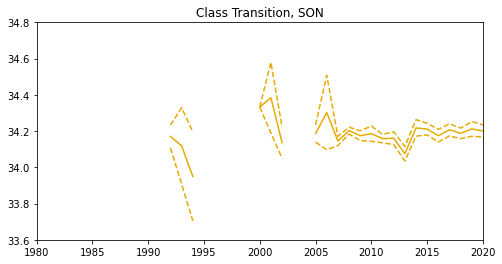

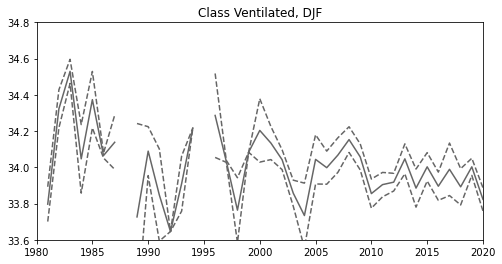

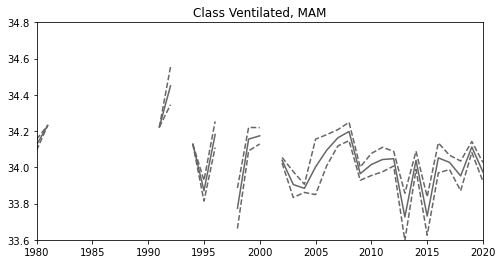

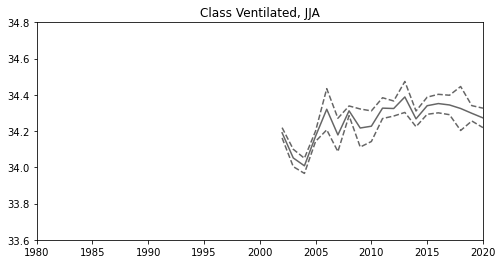

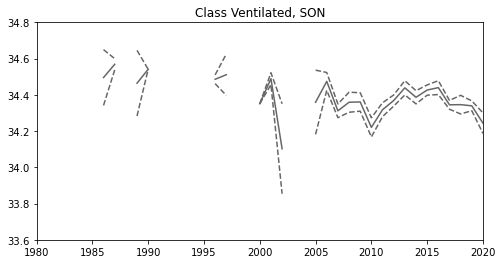

In [21]:
Smin_mean, Smin_std, Smin_N = at.calculate_stats_over_time(dfp, varName='Smin')
pt.plot_stats_from_analysis(ploc, dfp, Smin_mean, Smin_std, Smin_N, colormap, n_components_selected, varName='Smin', xlim=[1980,2020], ylim=[33.6, 34.8])

### MLD

analysis.calculate_stats_over_time


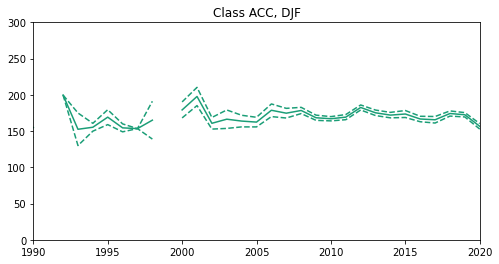

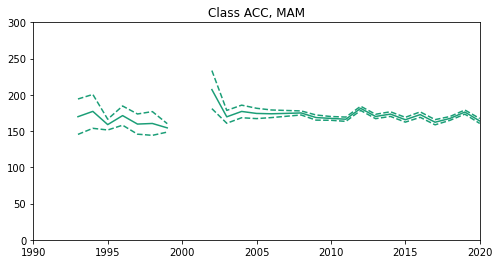

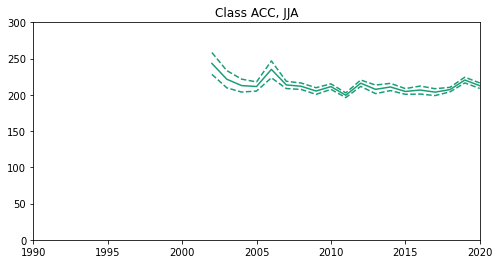

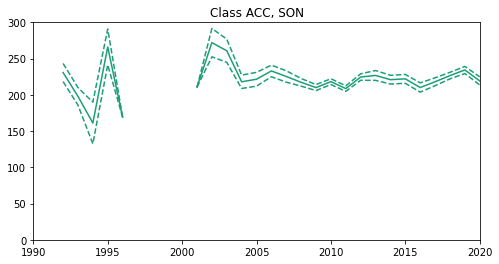

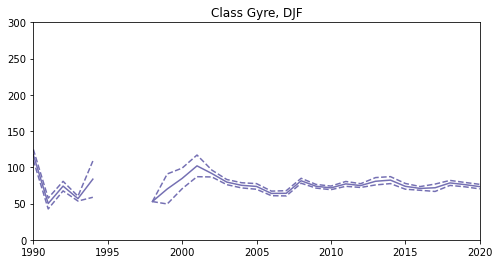

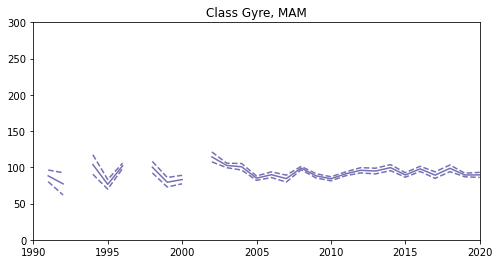

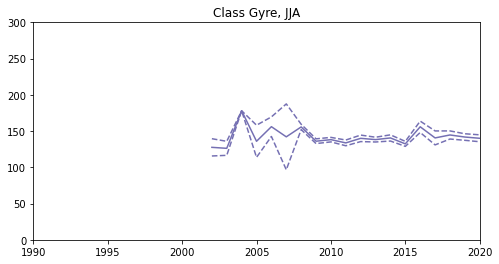

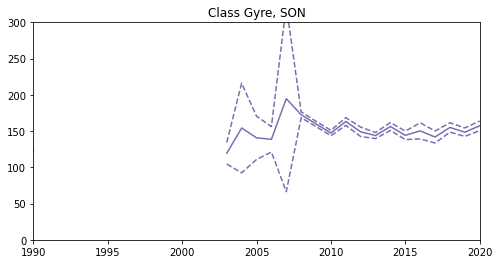

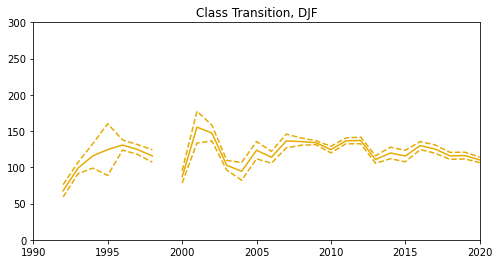

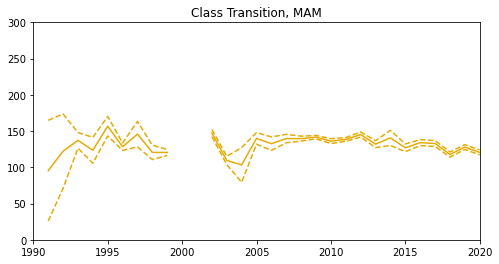

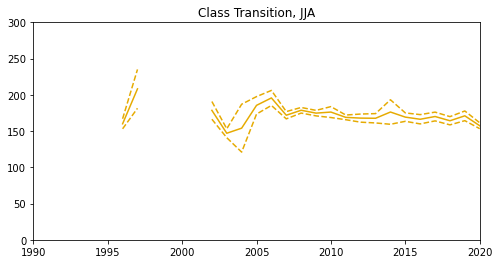

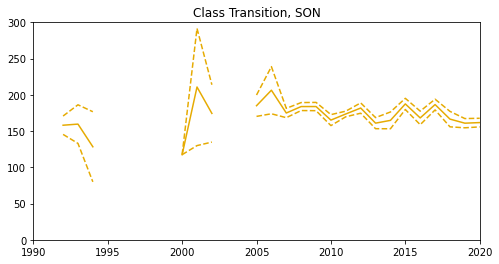

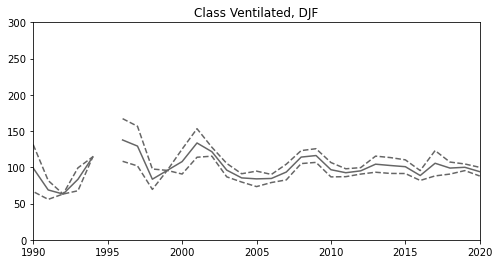

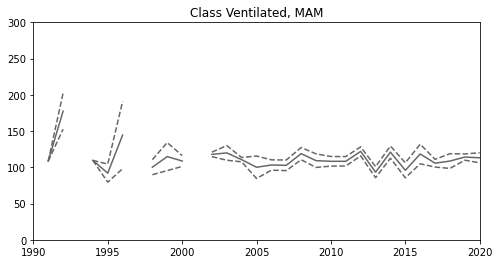

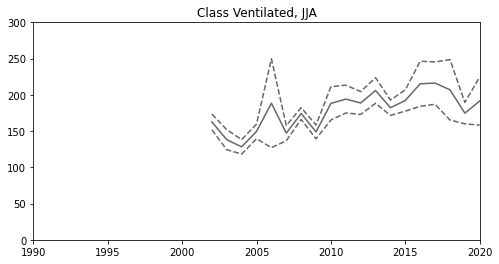

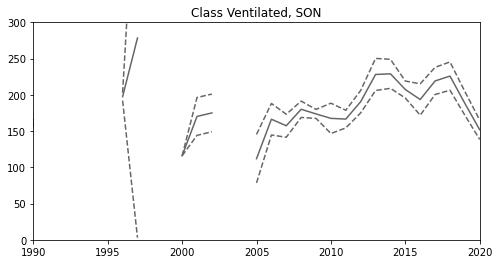

In [22]:
mld_mean, mld_std, mld_N = at.calculate_stats_over_time(dfp, varName='mld')
pt.plot_stats_from_analysis(ploc, dfp, mld_mean, mld_std, mld_N, colormap, n_components_selected, varName='mld', xlim=[1990,2020], ylim=[0,300])

### Near-surface stratification

analysis.calculate_stats_over_time


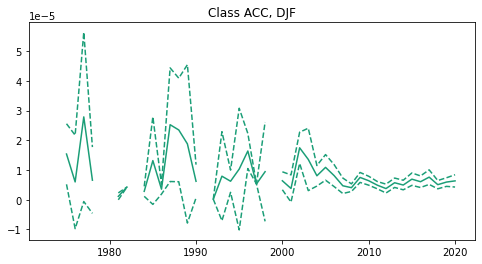

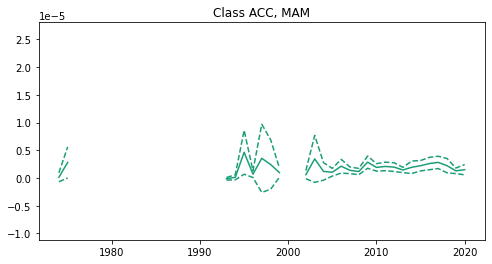

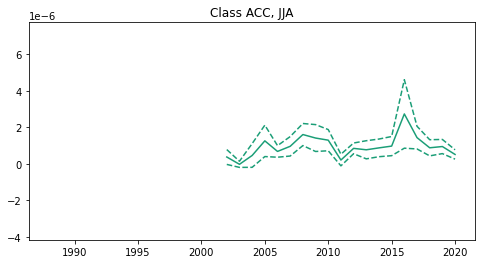

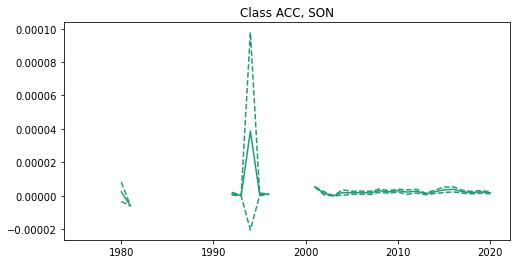

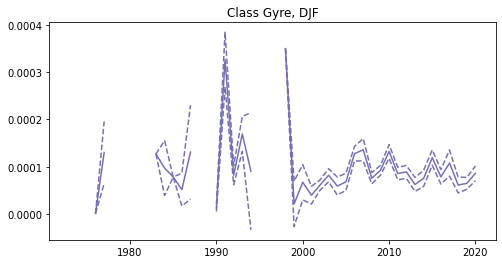

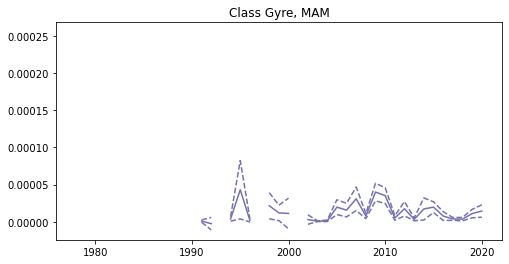

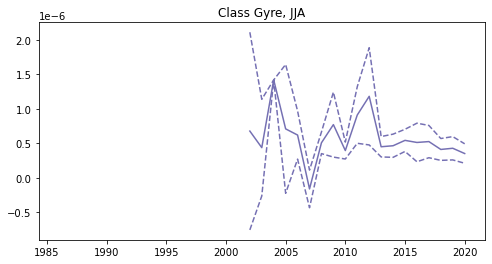

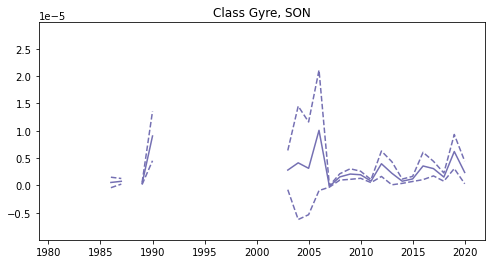

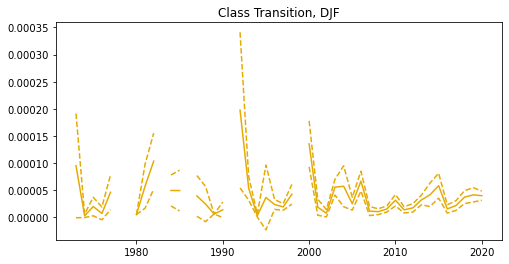

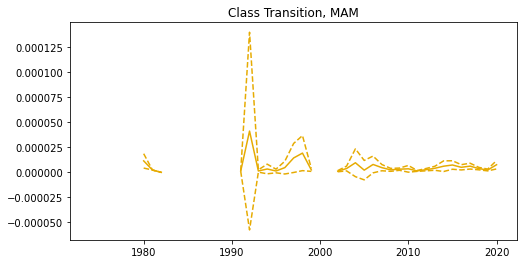

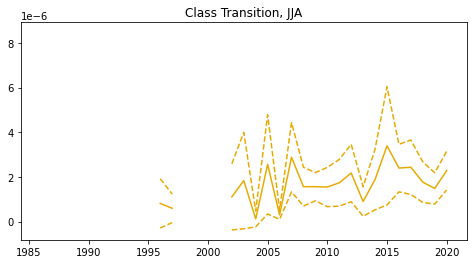

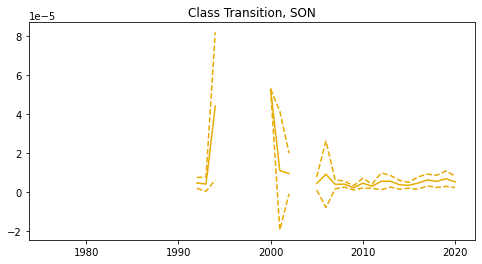

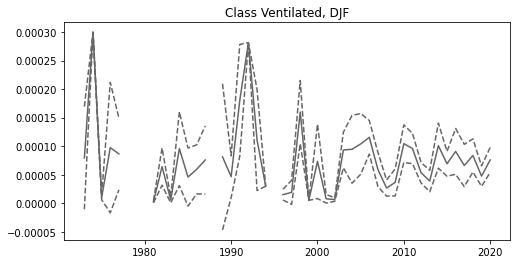

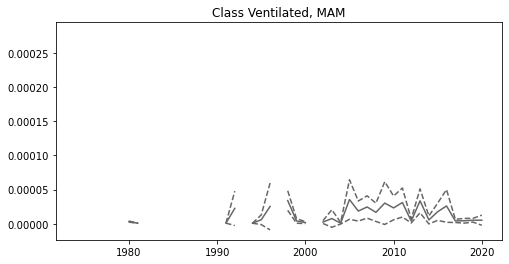

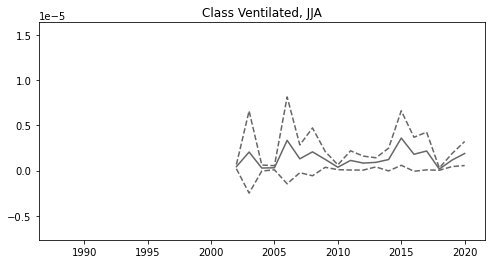

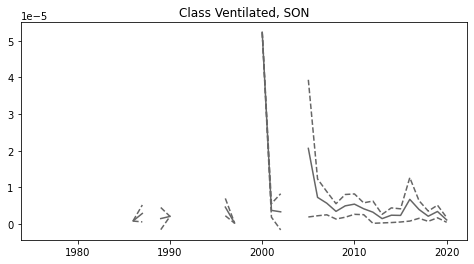

In [23]:
N2_mean, N2_std, N2_N = at.calculate_stats_over_time(dfp, varName='Nsquared_surface')
pt.plot_stats_from_analysis(ploc, dfp, N2_mean, N2_std, N2_N, colormap, n_components_selected, varName='Nsquared_surface')

### Depth of temperature maximum

analysis.calculate_stats_over_time


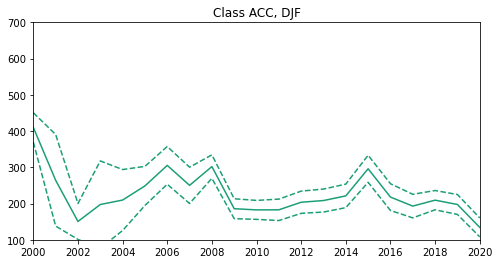

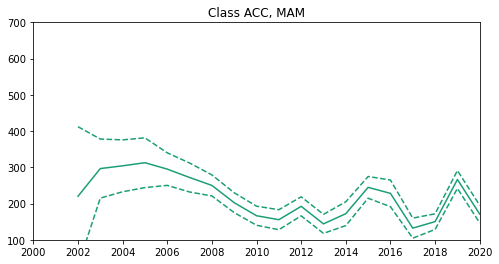

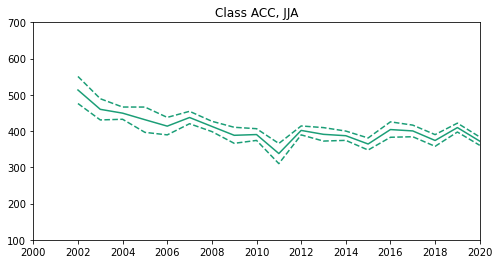

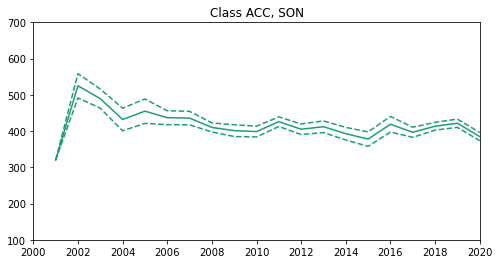

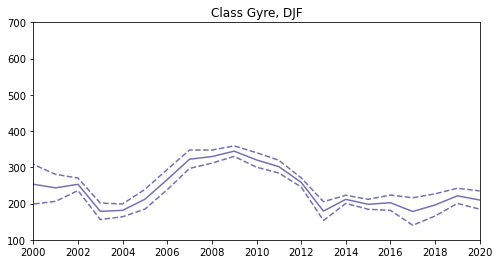

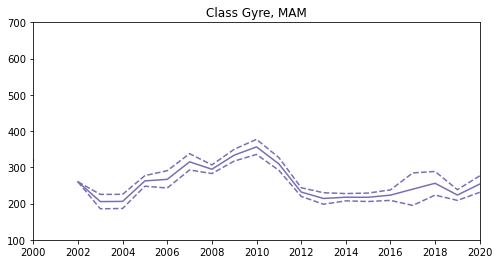

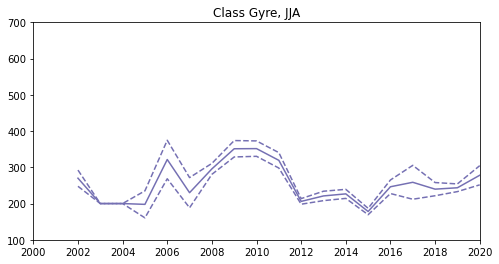

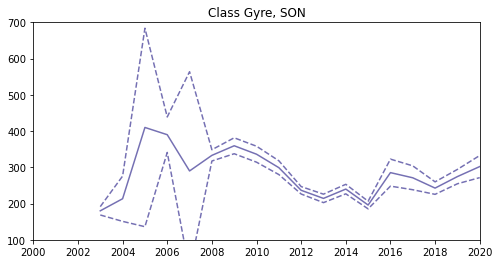

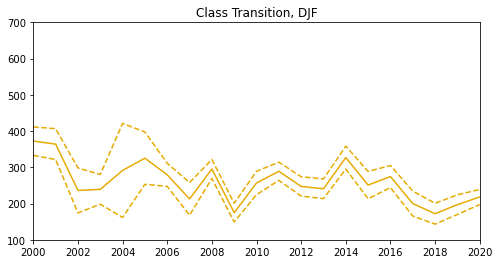

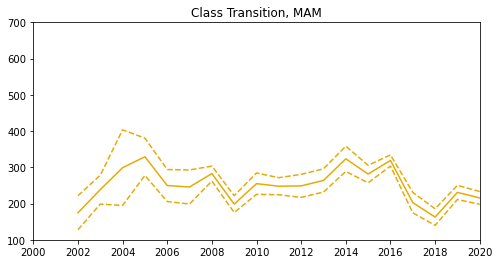

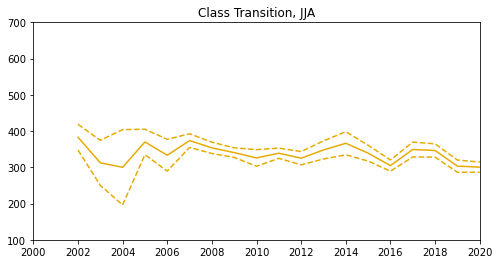

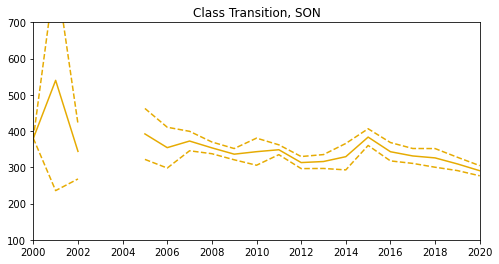

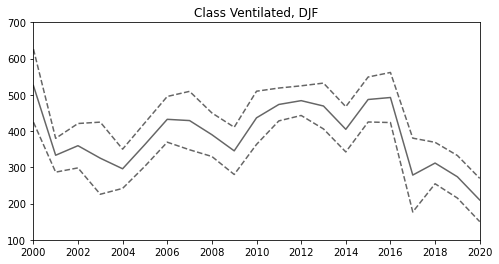

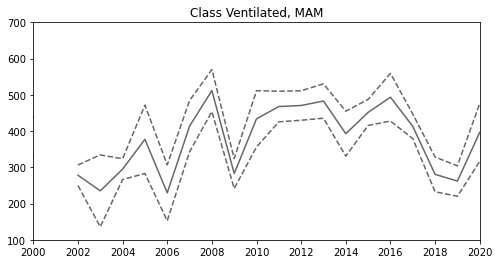

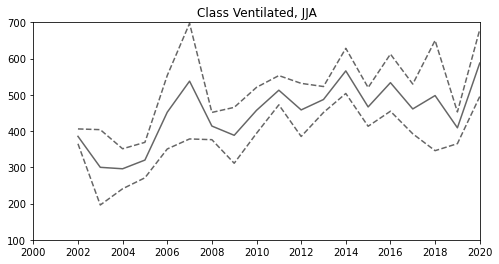

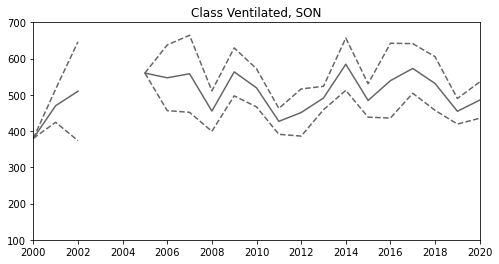

In [85]:
Tmaxd_mean, Tmaxd_std, Tmaxd_N = at.calculate_stats_over_time(dfp, varName='Tmax_depth')
plot_stats_from_analysis(ploc, dfp, Tmaxd_mean, Tmaxd_std, Tmaxd_N, colormap, n_components_selected, varName='Tmax_depth', xlim=[2000, 2020], ylim=[100,700])

### Depth of temperature minimum

analysis.calculate_stats_over_time


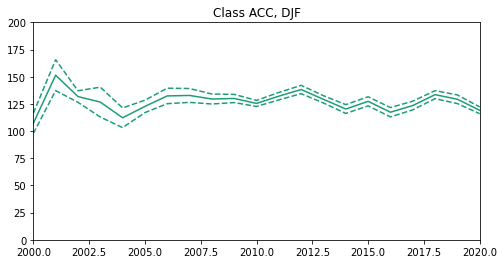

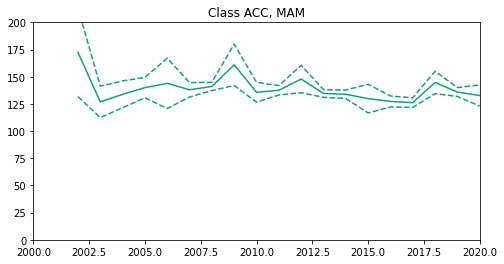

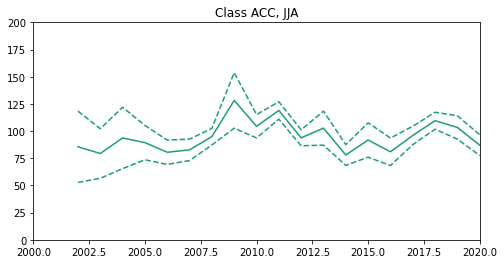

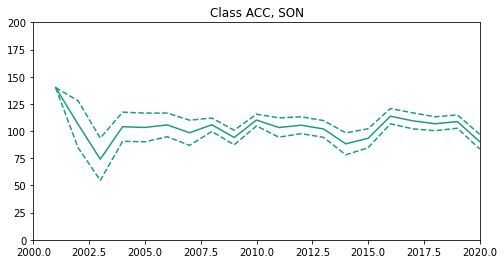

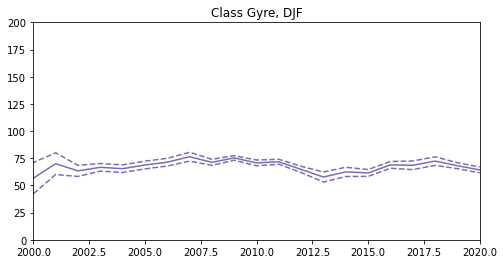

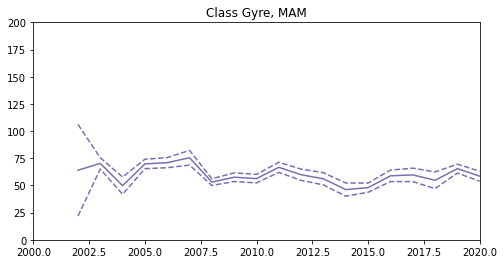

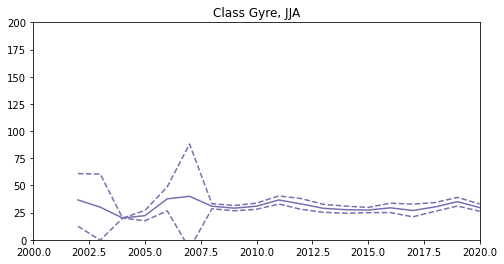

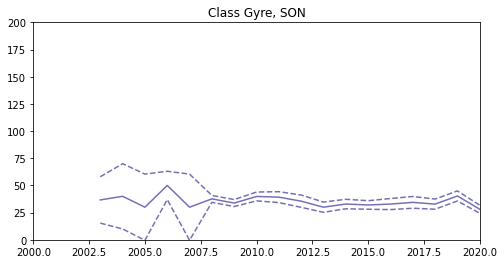

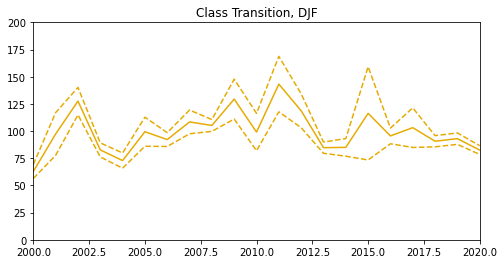

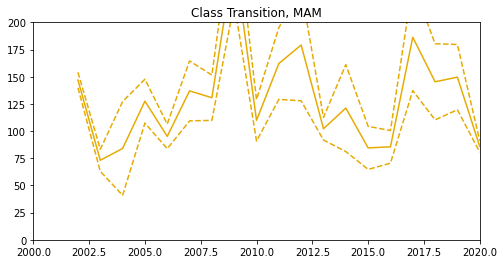

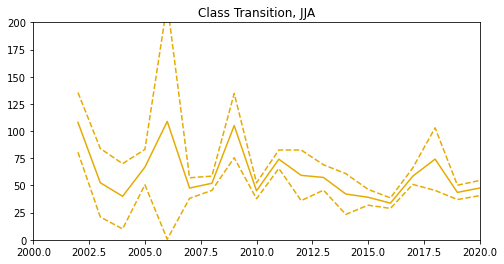

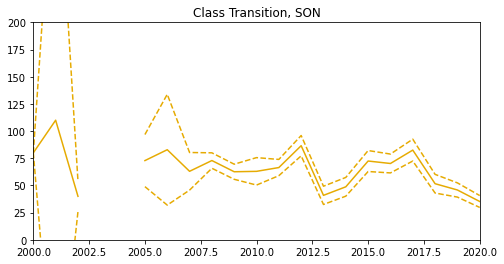

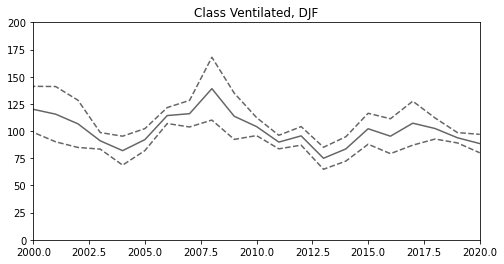

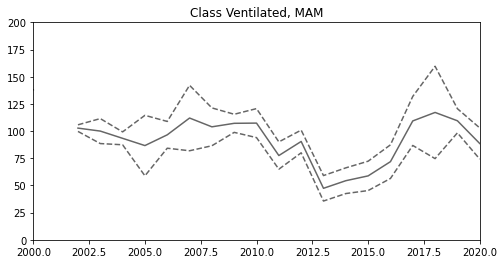

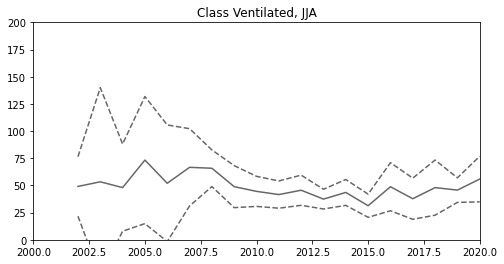

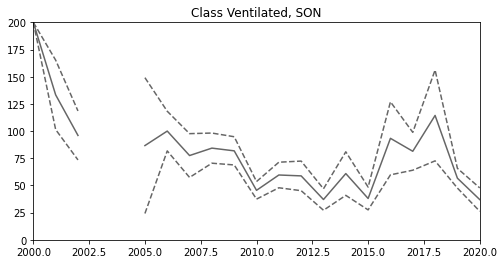

In [25]:
Tmind_mean, Tmind_std, Tmind_N = at.calculate_stats_over_time(dfp, varName='Tmin_depth')
pt.plot_stats_from_analysis(ploc, dfp, Tmind_mean, Tmind_std, Tmind_N, colormap, n_components_selected, varName='Tmin_depth', xlim=[2000, 2020], ylim=[0, 200])

### Linear regression of selected time series

In [26]:
dfp

<xarray.Dataset>
Dimensions:        (profile: 28397, depth: 21, CLASS: 4, depth_mid: 20)
Coordinates:
  * profile        (profile) int64 13 14 15 16 ... 142282 142301 142320 142330
    lon            (profile) float64 -26.44 -22.37 -17.38 ... 53.09 53.33 53.76
    lat            (profile) float64 -55.98 -56.81 -57.51 ... -58.46 -58.59
  * depth          (depth) float64 20.0 40.0 60.0 80.0 ... 820.0 910.0 1e+03
    time           (profile) datetime64[ns] 1973-01-11T12:00:00 ... 2020-10-1...
    year           (profile) int64 1973 1973 1973 1973 ... 2020 2020 2020 2020
    month          (profile) int64 1 1 1 1 1 1 1 1 1 1 ... 8 8 8 9 9 9 9 9 10 10
  * CLASS          (CLASS) int64 0 1 2 3
  * depth_mid      (depth_mid) float64 30.0 50.0 70.0 90.0 ... 775.0 865.0 955.0
    season         (profile) int64 1 1 1 1 1 1 1 1 1 1 1 ... 3 3 3 4 4 4 4 4 4 4
Data variables: (12/22)
    prof_date      (profile) float64 7.206e+05 7.206e+05 ... 7.381e+05 7.381e+05
    prof_YYYYMMDD  (profile) float64 1.973e+07 1.973e+07 ... 2.02e+07 2.02e+07
    prof_HHMMSS    (profile) float64 1.2e+05 1.2e+05 ... 4.45e+04 5.19e+04
    sig0           (profile, depth) float64 ...
    prof_SA        (profile, depth) float64 ...
    prof_CT        (profile, depth) float64 ...
    ...             ...
    Smin_depth     (profile) float64 20.0 20.0 20.0 20.0 ... 140.0 20.0 20.0
    Smax           (profile) float64 34.84 34.88 34.88 34.89 ... 34.9 34.9 34.9
    Smax_depth     (profile) float64 1e+03 730.0 910.0 ... 1e+03 1e+03 1e+03
    sig0min        (profile) float64 26.84 26.85 27.02 ... 27.32 27.29 27.27
    sig0max        (profile) float64 27.83 27.82 27.8 27.81 ... 27.8 27.8 27.8
    imetric        (profile) float64 0.005076 0.004052 0.5348 ... 0.2883 0.1321

In [27]:
ploc

'plots/plots_WeddellClassOnly_top1000m_K04_forPaper/'

# scratch space

In [57]:
def plot_hist_TS(ploc, df1D, n_components_selected,
                 sbins = np.arange(31, 38, 0.025),
                 tbins = np.arange(-2, 32, 0.1),
                 vartype='month',
                 crange=[0, 100],
                 colormap=cmocean.cm.phase,
                 moreText='',
                 fs=16.0):

    # print out
    print('plot_tools.plot_hist_map')

    # subdirectory
    dploc = ploc + 'TSdiagrams/'
    if not os.path.exists(dploc):
        os.makedirs(dploc)

    # import packages
    import gsw

    # T-S grid for density reference lines
    ctg, sag = np.meshgrid(tbins, sbins)
    sig0_grid = gsw.density.sigma0(sag, ctg)

    # loop over classes, create one histogram plot per class
    for iclass in range(n_components_selected):

        # random sample for plotting
        df1 = df1D.where(df1D.label==iclass, drop=True)

        # select variable
        if vartype=="month":
            myVar = df1.month
            varName = 'Month'
        elif vartype=="year":
            myVar = df1.year
            varName = 'Year'
        elif vartype=="imetric":
            myVar = df1.imetric
            varName = 'I-metric'
        elif vartype=="dyn_height":
            myVar = df1.dyn_height
            varName = 'Dynamic height (m)'
        elif vartype=="sig0":
            myVar = df1.sig0
            varName = '\sigma_0'
        elif vartype=="mld":
            myVar = df1.mld
            varName = 'Mixed layer depth (m)'
        else:
            print("Options include: month, year, imetric, dyn_height, sig0, mld")

        # histogram ()
        hist_denominator = histogram(df1.prof_SA,
                                     df1.prof_CT,
                                     bins=[sbins, tbins])
        hist_numerator = histogram(df1.prof_SA,
                                   df1.prof_CT,
                                   bins=[sbins, tbins],
                                   weights=myVar)
        histTS = hist_numerator/hist_denominator
        histTS = histTS.T

        # --- plot histogram
        plt.figure(figsize=(10,10))

        # TS histogram
        if vartype=="month":
            TS = histTS.plot(levels=12, cmap=colormap)
        else:
            TS = histTS.plot(levels=12, cmap=colormap, vmin=crange[0], vmax=crange[1])

        # grid
        CL = plt.contour(sag, ctg, sig0_grid, colors='black', zorder=1)
        TS.colorbar.set_label(varName)
        plt.clabel(CL, fontsize=fs, inline=False, fmt='%.1f') 
        plt.xlabel('Absolute salinity (psu)', fontsize=fs)
        plt.ylabel('Conservative temperature (°C)', fontsize=fs)
        plt.xlim(sbins[0], sbins[-1])
        plt.ylim(tbins[0], tbins[-1])
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.savefig(dploc + 'histogram_' + vartype + '_class' + str(iclass) + moreText + '.png', bbox_inches='tight')
        plt.savefig(dploc + 'histogram_depth' + vartype + '_class' + str(iclass) + moreText + '.pdf', bbox_inches='tight')
        plt.show()
        plt.close()

In [49]:
#####################################################################

import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
import matplotlib.patches as mpatches
import pandas as pd
from sklearn import manifold
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import cmocean
from xhistogram.xarray import histogram
### os tools
import os.path
from glob import glob
import file_io as io
import density
import random
import gsw

In [70]:
def plot_stats_from_analysis(ploc, df, f_mean, f_std, f_N, colormap, n_components_selected, varName='Blank', xlim=[], ylim=[], alpha=0.025):
    
    from matplotlib.ticker import MaxNLocator
    
    # use t-test for 95% confidence interval in the mean
    # slightly dodgy assumption that samples are independent
    from scipy.stats import t
    tvals = t.ppf(1 - alpha, df=f_N)
    
    # select colormap
    cNorm = colors.Normalize(vmin=0, vmax=n_components_selected)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)
    
    # calculate years for x-axis
    years = range(int(df.year.values.min()), int(df.year.values.max())+1)
    
    # class names string
    class_str = ["ACC", "Gyre", "Transition", "Ventilated"]
    
    # season string
    season_str = ["DJF", "MAM", "JJA", "SON"]
    
    iclass = 0
    iseason = 0
    
    for iclass in range(0,4):
        
        colorVal = scalarMap.to_rgba(iclass)
        
        for iseason in range(0,4):
    
            f_sample_mean = f_mean[iclass,:,iseason]
            f_SE = f_std[iclass,:,iseason]/np.sqrt(f_N[iclass,:,iseason])
            tval_select = tvals[iclass,:,iseason]

            h = plt.figure(figsize=(8,4))
            plt.plot(years, f_sample_mean, color=colorVal, linestyle='-')
            plt.plot(years, f_sample_mean + f_SE*tval_select, color=colorVal, linestyle='--')
            plt.plot(years, f_sample_mean - f_SE*tval_select, color=colorVal, linestyle='--')
            plt.title('Class ' + class_str[iclass] + ', ' + season_str[iseason])
            
            ax = h.gca()
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            
            if xlim:
                plt.xlim(xlim[0],xlim[1])
            if ylim:
                plt.ylim(ylim[0],ylim[1])
            
            plt.savefig(ploc + varName + '_stats' + '_class' + str(iclass) + '_season' + str(iseason) + '.png')
            plt.savefig(ploc + varName + '_stats' + '_class' + str(iclass) + '_season' + str(iseason) + '.pdf')
            plt.show()
            plt.close()